# Calculating functional and taxonomic diversity of transporters

## Overview

Here we will use the [Shannon diversity index](https://en.wikipedia.org/wiki/Diversity_index) to calculate both taxonomic diversity of transporters and functional diversity of most abundant taxa in each sample.

In [1]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.patches as mpatches
from scipy.stats import spearmanr, wilcoxon
import numpy as np
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')


## Functionality

In [2]:
def filter_low_abundance(df, f=0.5):
    # Calculate mean abundance of transporters
    df_trans_mean = df.groupby(["fam","transporter"]).sum().reset_index().groupby(["transporter"]).mean()
    # Normalize to percent
    n = df_trans_mean.div(df_trans_mean.sum())*100
    # Filter to those with max % >= to the threshold
    n = n.loc[n.max(axis=1)>=f]
    return set(n.index)


In [3]:
def shannon_proportions(counts,base=2):
    '''Modified version of shannon to handle proportions instead of absolute counts.'''
    # Generate list of floats
    counts = [float(item) for item in counts]
    counts = np.asarray(counts)
    if counts.sum()==0: return -1,0
    # frequencies are 
    freqs = counts / counts.sum()
    nonzero_freqs = freqs[freqs.nonzero()]
    return -(nonzero_freqs * np.log(nonzero_freqs)).sum() / np.log(base),len(nonzero_freqs)


In [4]:
def transporter_taxonomic_diversity(df,ranks,transporters,data_type,taxa):
    data = pd.DataFrame(columns=["rank","sample","transporter","dataset","taxa","diversity","num_taxa"])
    index = -1
    for rank in ranks:
        # Sum to abundance per family for each rank
        tmp_sum = df.groupby([rank,"fam","transporter"]).sum().reset_index()
        # Get mean transporter abundance for each rank
        tmp_mean = tmp_sum.groupby(["transporter",rank]).mean().reset_index()
        samples = tmp_mean.columns[2:]
        for transporter in transporters:
            # Get transporter data
            tmp_trans = tmp_mean.loc[tmp_mean.transporter==transporter] 
            # Sum for the current rank and transporter
            tmp_trans_rank = tmp_trans.groupby(rank).sum() 
            # Normalize to % in each sample
            tmp_trans_rank_norm = tmp_trans_rank.div(tmp_trans_rank.sum())*100
            # Fill gaps
            tmp_trans_rank_norm.fillna(0,inplace=True)
            # For each sample, calculate diversity and number of taxa for this transporter
            for sample in samples:
                div,num_taxa = shannon_proportions(tmp_trans_rank_norm[sample])
                index+=1
                df_tmp = pd.DataFrame(index=[index],data={"rank":rank,"taxa":taxa,"dataset":data_type,"sample":sample,"transporter":transporter,"diversity":div,"num_taxa":num_taxa})
                data = pd.concat([data,df_tmp])
    return data

In [5]:
def taxonomic_functional_diversity(df,rank,data_type,t_quantile=0.9):
    # Create empty dataframe
    data = pd.DataFrame(columns=["taxa","sample","type","diversity","num_transporters"])
    # Sum to abundance per family for each rank
    tmp_sum = df.groupby([rank,"fam","transporter"]).sum().reset_index()
    # Get mean transporter abundance for each rank
    tmp_mean = tmp_sum.groupby(["transporter",rank]).mean().reset_index()
    # Get total transporter abundance for each rank (sum over all transporters)
    # Also remove unclassified orders and environmental samples
    tmp_mean = tmp_mean.loc[~tmp_mean[rank].str.contains("unclassified", case=False)]
    tmp_mean = tmp_mean.loc[~tmp_mean[rank].str.contains("environmental samples", case=False)]
    tmp_trans_tax_sum = tmp_mean.groupby(rank).sum()    
    samples = tmp_mean.columns[2:]
    index=-1
    for sample in samples:
        # Calculate taxa that make up the quantiles for the transporter data
        q_trans_taxa = list(tmp_trans_tax_sum.loc[tmp_trans_tax_sum[sample]>tmp_trans_tax_sum[sample].quantile(q=t_quantile)].index)
        sample_taxa = q_trans_taxa
        for tax in sample_taxa:
            # Get tax data
            tmp_tax_trans = tmp_mean.loc[tmp_mean[rank]==tax,sample] 
            # Normalize
            tmp_tax_trans_norm = tmp_tax_trans.div(tmp_tax_trans.sum())*100
            # Calculate diversity and number of transporters for this order in this sample
            div,num_transporters = shannon_proportions(tmp_tax_trans_norm)
            index+=1
            # Add to dataframe
            df_tmp = pd.DataFrame(index=[index],data={"taxa":tax,"type":data_type,"sample":sample,"diversity":div,"num_transporters":num_transporters})
            data = pd.concat([data,df_tmp])
    taxsort = list(tmp_trans_tax_sum.loc[list(set(data.taxa))].mean(axis=1).sort_values(ascending=False).index)
    return data,taxsort

## Read sample groups

In [6]:
mg_groups = pd.read_csv("results/mg/samplegroups.tab", index_col=0, sep="\t")
mg_groups.rename(index=lambda x: str(x), inplace=True)


In [7]:
mt_groups = pd.read_csv("results/mt/samplegroups.tab", index_col=0, sep="\t")
mt_groups.rename(index=lambda x: str(x), inplace=True)


## Read transporter/taxonomic data

In [8]:
mg_taxcov = pd.read_table("results/mg/select_trans_genes.tpm.tsv", index_col=0)
mt_taxcov = pd.read_table("results/mt/select_trans_genes.tpm.tsv", index_col=0)

mg_all_taxcov = pd.read_table("results/mg/all_transporters.tpm.taxonomy.tsv.gz", index_col=0)
mt_all_taxcov = pd.read_table("results/mt/all_transporters.tpm.taxonomy.tsv.gz", index_col=0)

mg_all_taxraw = pd.read_table("results/mg/all_transporters.raw_counts.taxonomy.tsv.gz", index_col=0)
mt_all_taxraw = pd.read_table("results/mt/all_transporters.raw_counts.taxonomy.tsv.gz", index_col=0)


Filter low abundant transporters.

In [9]:
f = 0.5
mg_filtered = filter_low_abundance(mg_all_taxcov, f=f)
mt_filtered = filter_low_abundance(mt_all_taxcov, f=f)
all_filtered = list(mg_filtered.union(mt_filtered))
print("{} and {} ({} total) transporters with max % >= {} in the metagenomes and metatranscriptomes, respectively.".format(len(mg_filtered), len(mt_filtered), len(all_filtered), f))

81 and 84 (99 total) transporters with max % >= 0.5 in the metagenomes and metatranscriptomes, respectively.


In [10]:
mg_all_taxcov = mg_all_taxcov.loc[mg_all_taxcov.transporter.isin(all_filtered)]
mt_all_taxcov = mt_all_taxcov.loc[mt_all_taxcov.transporter.isin(all_filtered)]


In [11]:
mg_filtered_taxraw = mg_all_taxraw.loc[mg_all_taxraw.transporter.isin(all_filtered)]
mt_filtered_taxraw = mt_all_taxraw.loc[mt_all_taxraw.transporter.isin(all_filtered)]


Filter out orders to those that have at least 500 reads mapped on average across the datasets.

In [12]:
mg_filtered_taxraw_ordermean = mg_filtered_taxraw.groupby("order").sum().mean(axis=1)
mg_filtered_orders = mg_filtered_taxraw_ordermean.loc[(mg_filtered_taxraw_ordermean>=500)&(~mg_filtered_taxraw_ordermean.index.str.match("Unclassified"))].sort_values(ascending=False).index
print("\n".join(["{}: {} average reads".format(x,np.round(mg_filtered_taxraw_ordermean.loc[x],0)) for x in mg_filtered_orders]))

Flavobacteriales: 5413.0 average reads
Sphingobacteriales: 2626.0 average reads
Pelagibacterales: 1584.0 average reads
Cellvibrionales: 1530.0 average reads
Rhodobacterales: 998.0 average reads
Burkholderiales: 600.0 average reads
Opitutales: 592.0 average reads
Mamiellales: 546.0 average reads


In [13]:
mt_filtered_taxraw_ordermean = mt_filtered_taxraw.groupby("order").sum().mean(axis=1)
mt_filtered_orders = mt_filtered_taxraw_ordermean.loc[(mt_filtered_taxraw_ordermean>=500)&(~mt_filtered_taxraw_ordermean.index.str.match("Unclassified"))].sort_values(ascending=False).index
list(mt_filtered_orders)
print("\n".join(["{}: {} average reads".format(x,np.round(mt_filtered_taxraw_ordermean.loc[x],0)) for x in mt_filtered_orders]))

Flavobacteriales: 5976.0 average reads
Mamiellales: 1366.0 average reads
Cellvibrionales: 776.0 average reads
Sphingobacteriales: 613.0 average reads


Read information on transporters.

In [14]:
transinfo = pd.read_csv("selected_transporters_classified_P.tab", index_col=0, header=0, sep="\t")

In [15]:
categories = ["Anions","Cations","Nitrate","Metal","Urea","Phosphate","Phosphonate","AA peptide + (NH4+)","Nucleoside","Carbohydrate"]

In [16]:
genera = mg_all_taxcov.loc[(mg_all_taxcov.transporter.isin(transinfo.index))&(mg_all_taxcov["order"].isin(mg_filtered_orders)),"genus"].unique()
len([x for x in genera if not "Unclassified" in x])

13

## Plot profiles for select transporter substrates


Generate transporter mean
s in each taxgroup.

In [17]:
mg_df = mg_all_taxcov.copy(deep=True)
mt_df = mt_all_taxcov.copy(deep=True)

In [18]:
mg_bac_sum = mg_df.loc[(mg_df.superkingdom=="Bacteria")&(mg_df.phylum!="Cyanobacteria")].groupby(["fam","transporter"]).sum().reset_index()
mg_bac_mean = mg_bac_sum.groupby("transporter").mean()
mg_bac_meanp = mg_bac_mean.div(mg_bac_mean.sum())*100
mg_bac_meanp = pd.merge(transinfo,mg_bac_meanp,left_index=True, right_index=True)
mg_bac_melt = pd.melt(mg_bac_meanp.reset_index()[["transporter","substrate_category"]+list(mg_bac_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mg_bac_melt = mg_bac_melt.assign(Taxgroup=pd.Series(["Bacteria"]*len(mg_bac_melt)))

In [19]:
mg_arc_sum = mg_df.loc[(mg_df.superkingdom=="Archaea")].groupby(["fam","transporter"]).sum().reset_index()
mg_arc_mean = mg_arc_sum.groupby("transporter").mean()
mg_arc_meanp = mg_arc_mean.div(mg_arc_mean.sum())*100
mg_arc_meanp = pd.merge(transinfo,mg_arc_meanp,left_index=True, right_index=True)
mg_arc_melt = pd.melt(mg_arc_meanp.reset_index()[["transporter","substrate_category"]+list(mg_arc_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mg_arc_melt = mg_arc_melt.assign(Taxgroup=pd.Series(["Archaea"]*len(mg_arc_melt)))

In [20]:
mg_cya_sum = mg_df.loc[(mg_df.phylum=="Cyanobacteria")].groupby(["fam","transporter"]).sum().reset_index()
mg_cya_mean = mg_cya_sum.groupby("transporter").mean()
mg_cya_meanp = mg_cya_mean.div(mg_cya_mean.sum())*100
mg_cya_meanp = pd.merge(transinfo,mg_cya_meanp,left_index=True, right_index=True)
mg_cya_melt = pd.melt(mg_cya_meanp.reset_index()[["transporter","substrate_category"]+list(mg_cya_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mg_cya_melt = mg_cya_melt.assign(Taxgroup=pd.Series(["Cyanobacteria"]*len(mg_cya_melt)))

In [21]:
mg_euk_sum = mg_df.loc[(mg_df.superkingdom=="Eukaryota")].groupby(["fam","transporter"]).sum().reset_index()
mg_euk_mean = mg_euk_sum.groupby("transporter").mean()
mg_euk_meanp = mg_euk_mean.div(mg_euk_mean.sum())*100
mg_euk_meanp = pd.merge(transinfo,mg_euk_meanp,left_index=True, right_index=True)
mg_euk_melt = pd.melt(mg_euk_meanp.reset_index()[["transporter","substrate_category"]+list(mg_euk_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mg_euk_melt = mg_euk_melt.assign(Taxgroup=pd.Series(["Eukaryota"]*len(mg_euk_melt)))

In [22]:
mg_melt = pd.concat([mg_bac_melt,mg_cya_melt])
mg_melt = pd.concat([mg_melt,mg_arc_melt])
mg_melt = pd.concat([mg_melt,mg_euk_melt])

In [23]:
mt_bac_sum = mt_df.loc[(mt_df.superkingdom=="Bacteria")&(mt_df.phylum!="Cyanobacteria")].groupby(["fam","transporter"]).sum().reset_index()
mt_bac_mean = mt_bac_sum.groupby("transporter").mean()
mt_bac_meanp = mt_bac_mean.div(mt_bac_mean.sum())*100
mt_bac_meanp = pd.merge(transinfo,mt_bac_meanp,left_index=True, right_index=True)
mt_bac_melt = pd.melt(mt_bac_meanp.reset_index()[["transporter","substrate_category"]+list(mt_bac_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mt_bac_melt = mt_bac_melt.assign(Taxgroup=pd.Series(["Bacteria"]*len(mt_bac_melt)))

In [24]:
mt_arc_sum = mt_df.loc[(mt_df.superkingdom=="Archaea")].groupby(["fam","transporter"]).sum().reset_index()
mt_arc_mean = mt_arc_sum.groupby("transporter").mean()
mt_arc_meanp = mt_arc_mean.div(mt_arc_mean.sum())*100
mt_arc_meanp = pd.merge(transinfo,mt_arc_meanp,left_index=True, right_index=True)
mt_arc_melt = pd.melt(mt_arc_meanp.reset_index()[["transporter","substrate_category"]+list(mt_arc_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mt_arc_melt = mt_arc_melt.assign(Taxgroup=pd.Series(["Archaea"]*len(mt_arc_melt)))

In [25]:
mt_cya_sum = mt_df.loc[(mt_df.phylum=="Cyanobacteria")].groupby(["fam","transporter"]).sum().reset_index()
mt_cya_mean = mt_cya_sum.groupby("transporter").mean()
mt_cya_meanp = mt_cya_mean.div(mt_cya_mean.sum())*100
mt_cya_meanp = pd.merge(transinfo,mt_cya_meanp,left_index=True, right_index=True)
mt_cya_melt = pd.melt(mt_cya_meanp.reset_index()[["transporter","substrate_category"]+list(mt_cya_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mt_cya_melt = mt_cya_melt.assign(Taxgroup=pd.Series(["Cyanobacteria"]*len(mt_cya_melt)))

In [26]:
mt_euk_sum = mt_df.loc[(mt_df.superkingdom=="Eukaryota")].groupby(["fam","transporter"]).sum().reset_index()
mt_euk_mean = mt_euk_sum.groupby("transporter").mean()
mt_euk_meanp = mt_euk_mean.div(mt_euk_mean.sum())*100
mt_euk_meanp = pd.merge(transinfo,mt_euk_meanp,left_index=True, right_index=True)
mt_euk_melt = pd.melt(mt_euk_meanp.reset_index()[["transporter","substrate_category"]+list(mt_euk_mean.columns)],id_vars=["transporter","substrate_category"], var_name="Sample", value_name="%taxgroup")
mt_euk_melt = mt_euk_melt.assign(Taxgroup=pd.Series(["Eukaryota"]*len(mt_euk_melt)))

In [27]:
mt_melt = pd.concat([mt_bac_melt,mt_cya_melt])
mt_melt = pd.concat([mt_melt,mt_arc_melt])
mt_melt = pd.concat([mt_melt,mt_euk_melt])

Show contribution of different taxgroups to total transporters.

In [28]:
b = pd.DataFrame(mg_bac_mean.sum(), columns=["Bac"])
c = pd.DataFrame(mg_cya_mean.sum(), columns=["Cya"])
e = pd.DataFrame(mg_euk_mean.sum(), columns=["Euk"])
bce = pd.concat([e,pd.concat([b,c],axis=1)],axis=1)
bce.sum().div(bce.sum().sum())*100

Euk     2.234317
Bac    96.306349
Cya     1.459334
dtype: float64

In [29]:
b = pd.DataFrame(mt_bac_mean.sum(), columns=["Bac"])
c = pd.DataFrame(mt_cya_mean.sum(), columns=["Cya"])
e = pd.DataFrame(mt_euk_mean.sum(), columns=["Euk"])
bce = pd.concat([e,pd.concat([b,c],axis=1)],axis=1)
bce.sum().div(bce.sum().sum())*100

Euk     6.574099
Bac    89.659088
Cya     3.766813
dtype: float64

In [30]:
def plot_indiv_trans(df, cats, pal="Set1", outfile=None):
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
    plot_data = df.loc[df.substrate_category.isin(cats)]
    renamed_trans = []
    for t in plot_data.transporter:
        renamed_trans.append("{} ({})".format(t,transinfo.loc[t,"name"]))
    plot_data = plot_data.assign(Transporter=pd.Series(renamed_trans,index=plot_data.index))
    palette = dict(zip(plot_data.Transporter.unique(), sns.color_palette(pal, n_colors=len(plot_data.Transporter.unique()))))
    for i, taxgroup in enumerate(["Bacteria","Eukaryota","Cyanobacteria"]):
        if len(plot_data.loc[plot_data.Taxgroup==taxgroup]) > 0:
            ax = sns.pointplot(data=plot_data.loc[plot_data.Taxgroup==taxgroup], x="Sample",y="%taxgroup", 
                               hue="Transporter", scale=0.5, ax=axes[i], palette=palette, legend=False)
            ax.get_legend().remove()
            if i>0:
                ax.set_ylabel("")
            else:
                ax.set_ylabel("% of transporter in taxa")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
        else:
            axes[i].set_xticks(list(range(len(plot_data.Sample.unique()))))
            axes[i].set_xticklabels(plot_data.Sample.unique(), rotation=90, fontdict={"fontsize": 8})
        if taxgroup == "Eukaryota":
            title = "Picoeukaryota"
        else:
            title = taxgroup
        axes[i].set_title(title, fontsize=10)
    plt.subplots_adjust(wspace=0.1)
    # Set up legend
    handles = [mpatches.Patch(color=palette[x], label=x) for x in sorted(palette.keys())]
    legend = axes[2].legend(handles=handles, bbox_to_anchor=(1,1))
    legend.get_frame().set_facecolor('white')
    if outfile:
        plt.savefig(outfile, bbox_inches="tight")

### Phosphate/phosphonate

In [31]:
def generate_p_data(df):
    # Phosphate transporters
    pi = list(transinfo.loc[transinfo.substrate_category=="Phosphate"].index)
    # Phosphonate transporters
    po = list(transinfo.loc[transinfo.substrate_category=="Phosphonate"].index)
    # Generate sum of phosphate transporters
    df_pi = df.loc[df.transporter.isin(pi)]
    df_pi = df_pi.groupby(["substrate_category","Sample","Taxgroup"]).sum().reset_index()
    # Generate sum of phosphonate transporters
    df_po = df.loc[df.transporter.isin(po)]
    df_po = df_po.groupby(["substrate_category","Sample","Taxgroup"]).sum().reset_index()
    df_p = pd.concat([df_pi,df_po])
    return df_p

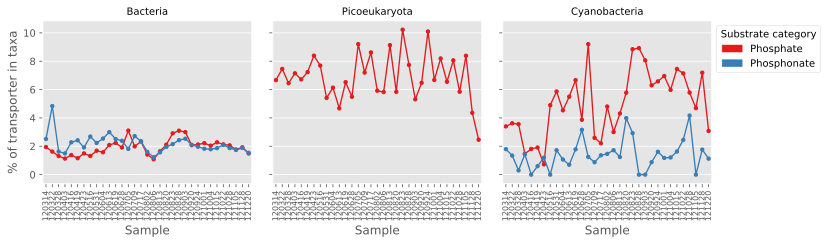

In [32]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
mg_p = generate_p_data(mg_melt)
for i, taxgroup in enumerate(["Bacteria","Eukaryota","Cyanobacteria"]):
    ax = sns.pointplot(data=mg_p.loc[mg_p.Taxgroup==taxgroup], x="Sample", y="%taxgroup", hue="substrate_category", palette="Set1",
                       ax=axes[i], legend=False, scale=0.5)
    ax.get_legend().remove()
    if i>0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("% of transporter in taxa")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
    if taxgroup == "Eukaryota":
        title = "Picoeukaryota"
    else:
        title = taxgroup
    ax.set_title(title, fontsize=10)
plt.subplots_adjust(wspace=0.1)
# Set up legend
handles = [mpatches.Patch(color=sns.color_palette("Set1", n_colors=2)[0], label='Phosphate'),
           mpatches.Patch(color=sns.color_palette("Set1", n_colors=2)[1], label='Phosphonate')]
legend = axes[2].legend(handles=handles, bbox_to_anchor=(1,1))
legend.get_frame().set_facecolor('white')
legend.set_title("Substrate category")
plt.savefig("NEW_figures_2020/Figure_7A.eps", bbox_inches="tight")

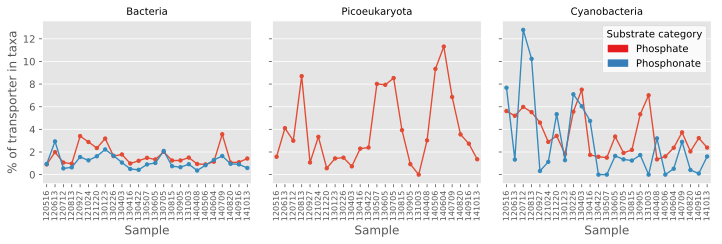

In [33]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,3), sharey=True)
mt_p = generate_p_data(mt_melt)
for i, taxgroup in enumerate(["Bacteria","Eukaryota","Cyanobacteria"]):
    ax = sns.pointplot(data=mt_p.loc[mt_p.Taxgroup==taxgroup], x="Sample", y="%taxgroup", hue="substrate_category",
                       ax=axes[i], legend=False, scale=0.5)
    ax.get_legend().remove()
    if i>0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("% of transporter in taxa")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
    if taxgroup == "Eukaryota":
        title = "Picoeukaryota"
    else:
        title = taxgroup
    ax.set_title(title, fontsize=10)
plt.subplots_adjust(wspace=0.1)
# Set up legend
handles = [mpatches.Patch(color=sns.color_palette("Set1", n_colors=2)[0], label='Phosphate'),
           mpatches.Patch(color=sns.color_palette("Set1", n_colors=2)[1], label='Phosphonate')]
legend = axes[2].legend(handles=handles, bbox_to_anchor=(1,1))
legend.get_frame().set_facecolor('white')
legend.set_title("Substrate category")
plt.savefig("NEW_figures_2020/Figure_7A_MT.eps", bbox_inches="tight")



Plot individual transporters

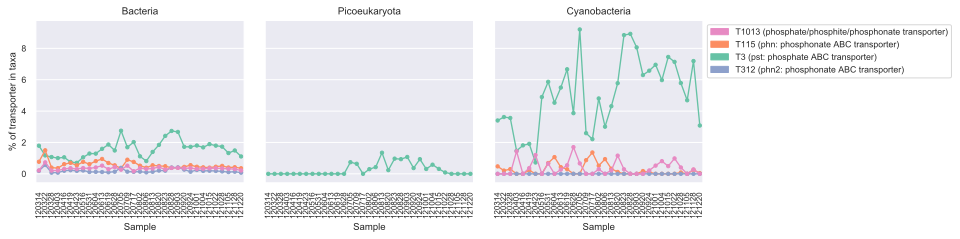

In [65]:
plot_indiv_trans(mg_melt, cats = ["Phosphate","Phosphonate"], pal="Set2")

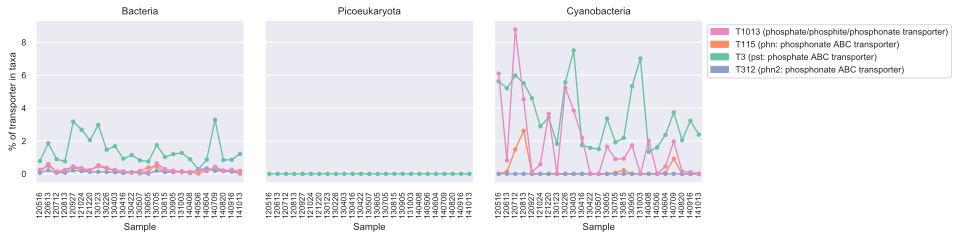

In [66]:
plot_indiv_trans(mt_melt, cats = ["Phosphate","Phosphonate"], pal="Set2")